In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [14]:
# Data Loading
df= pd.read_csv('exchange_rate.csv')
df.head()


,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [16]:

# Change 'date' column to datetime and set as index, specifying the correct format
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
df.set_index('date', inplace=True)

In [19]:
# Rename 'Ex_rate' to 'AUD' for consistency
df.rename(columns={'Ex_rate': 'AUD'}, inplace=True)


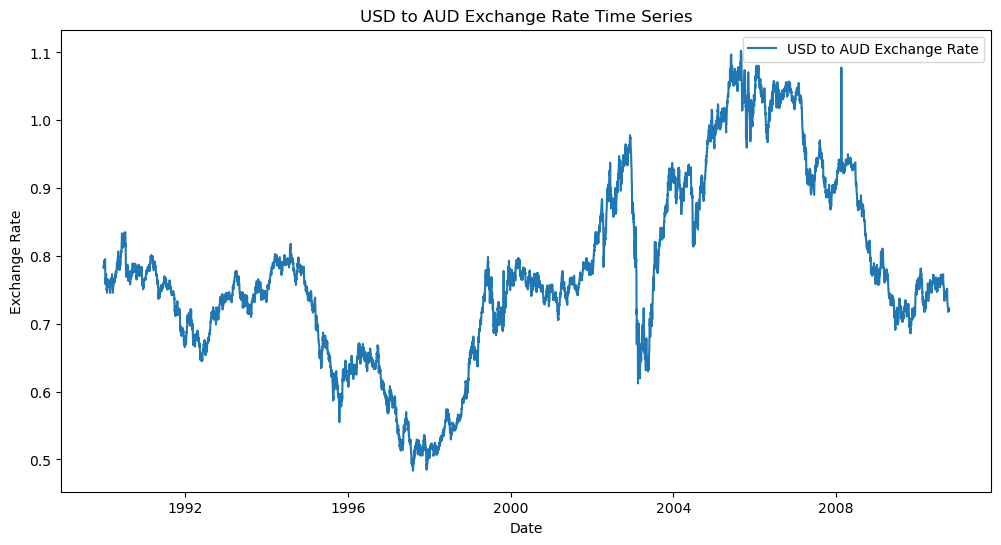

In [20]:
# Initial Exploration
plt.figure(figsize=(12, 6))
plt.plot(df['AUD'], label='USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [21]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 AUD    0
dtype: int64


In [24]:
# Data Preprocessing (Handling missing values)
df = df.fillna(method='ffill') # Forward fill missing values

C:\Users\udits\AppData\Local\Temp\ipykernel_19656\4172757223.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill') # Forward fill missing values


In [37]:
# Check for stationarity
result = adfuller(df['AUD'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.664994
p-value: 0.449233
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


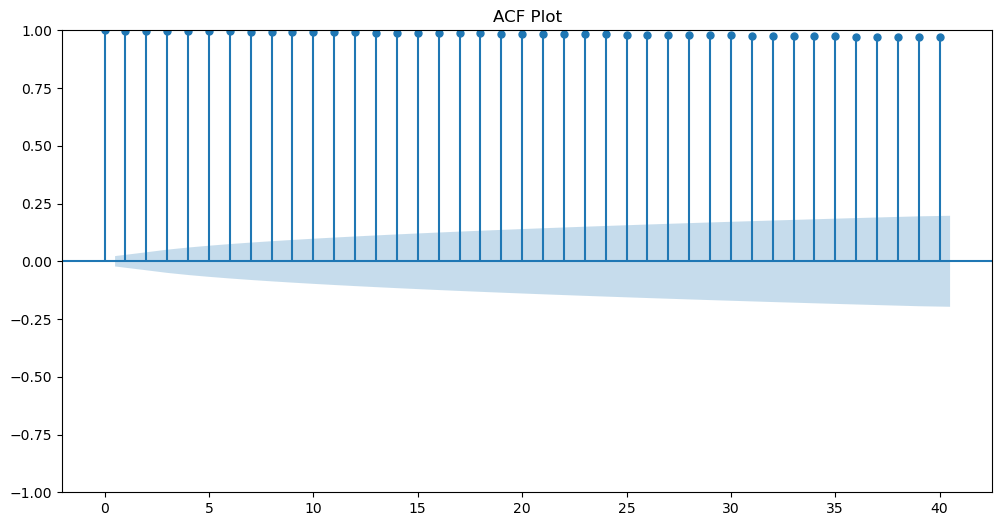

In [40]:
# Part 2: Model Building - ARIMA

# Parameter Selection for ARIMA (ACF and PACF plots)
plt.figure(figsize=(12, 6))
plot_acf(df['AUD'], lags=40, ax=plt.gca())
plt.title('ACF Plot')
plt.show()

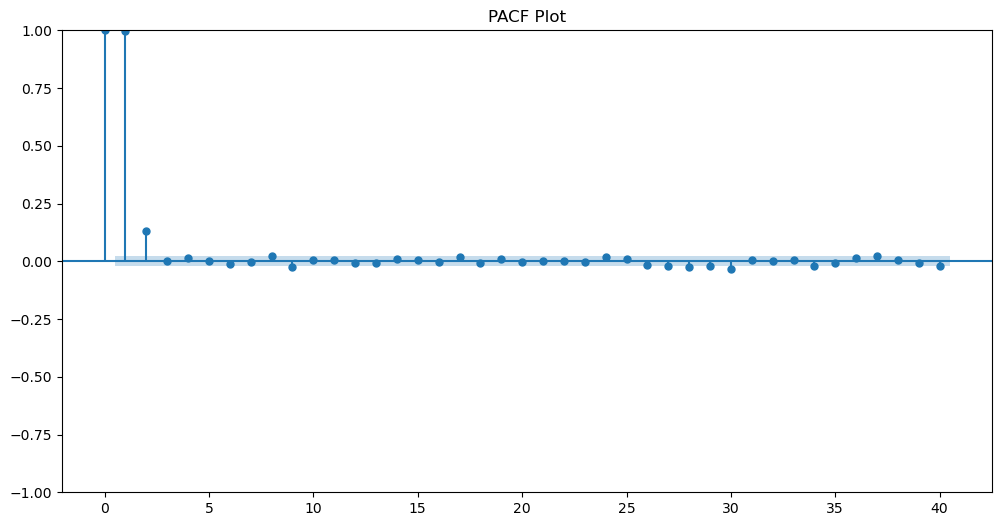

In [42]:
plt.figure(figsize=(12, 6))
plot_pacf(df['AUD'], lags=40, ax=plt.gca())
plt.title('PACF Plot')
plt.show()

In [28]:
# Based on ACF and PACF plots, ARIMA(1, 1, 0) is the most appropriate choice.
# We will fit this model and evaluate its performance.

In [34]:
# Assuming your data has a daily frequency
df.index.freq = 'D'

# Now, when you split the data:
train_size = int(len(df) * 0.8)
train, test = df['AUD'][:train_size], df['AUD'][train_size:]

model_arima_110 = ARIMA(train, order=(1, 1, 0))
model_arima_110_fit = model_arima_110.fit()

In [43]:
# Diagnostics (Residual analysis)
residuals_110 = pd.DataFrame(model_arima_110_fit.resid)


<Figure size 1200x600 with 0 Axes>

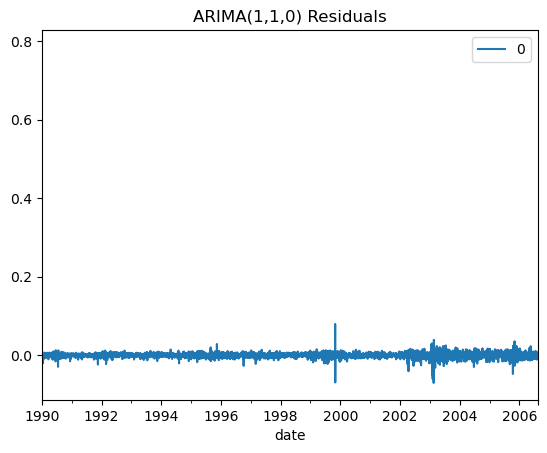

In [44]:
plt.figure(figsize=(12, 6))
residuals_110.plot()
plt.title('ARIMA(1,1,0) Residuals')
plt.show()

<Figure size 1200x600 with 0 Axes>

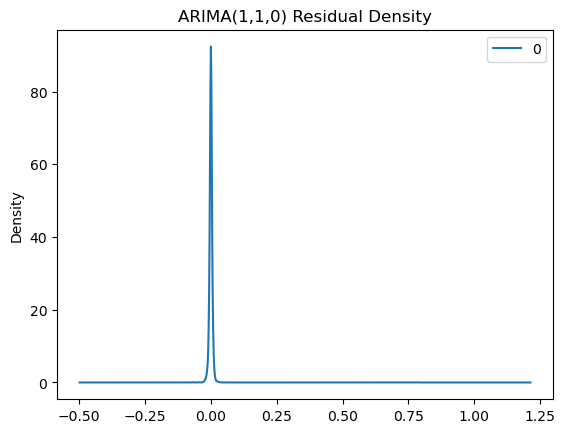

In [45]:
plt.figure(figsize=(12, 6))
residuals_110.plot(kind='kde')
plt.title('ARIMA(1,1,0) Residual Density')
plt.show()

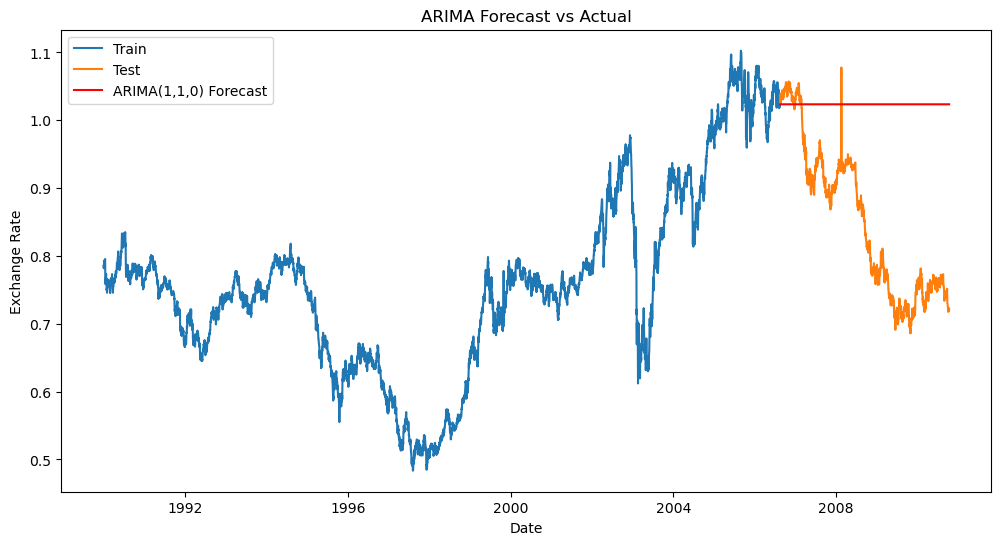

In [48]:
# Forecasting
forecast_110 = model_arima_110_fit.forecast(steps=len(test))
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_110, label='ARIMA(1,1,0) Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [49]:
# Part 3: Model Building - Exponential Smoothing

# Model Selection (Holt's Linear due to trend)
model_es = ExponentialSmoothing(train, trend='add', seasonal=None)
model_es_fit = model_es.fit()

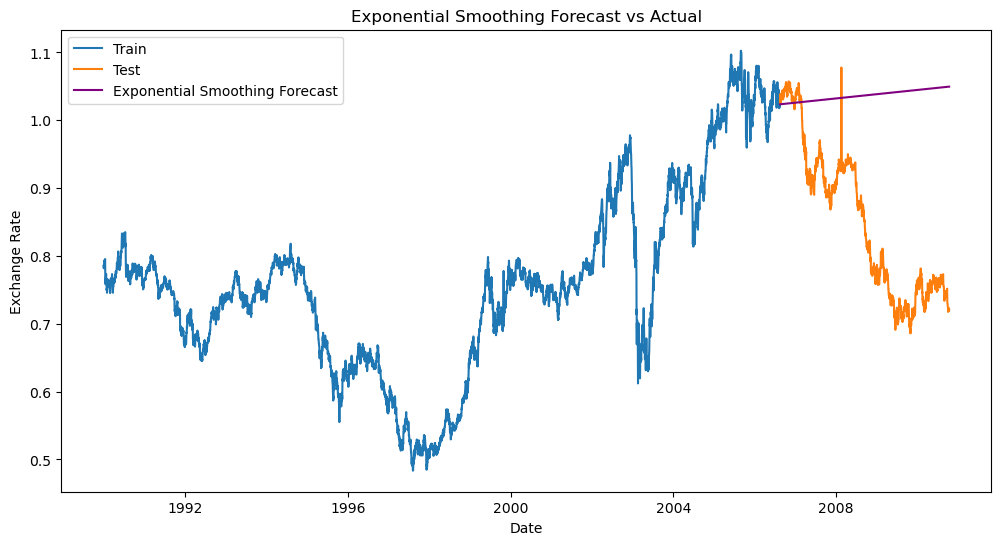

In [50]:
# Forecasting
forecast_es = model_es_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_es, label='Exponential Smoothing Forecast', color='purple')
plt.title('Exponential Smoothing Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [52]:
# Part 4: Evaluation and Comparison

# Compute Error Metrics
mae_arima_110 = mean_absolute_error(test, forecast_110)
rmse_arima_110 = np.sqrt(mean_squared_error(test, forecast_110))
mape_arima_110 = mean_absolute_percentage_error(test, forecast_110)

mae_es = mean_absolute_error(test, forecast_es)
rmse_es = np.sqrt(mean_squared_error(test, forecast_es))
mape_es = mean_absolute_percentage_error(test, forecast_es)

print("ARIMA(1,1,0) Metrics:")
print(f"MAE: {mae_arima_110:.4f}, RMSE: {rmse_arima_110:.4f}, MAPE: {mape_arima_110:.4f}")

print("Exponential Smoothing Metrics:")
print(f"MAE: {mae_es:.4f}, RMSE: {rmse_es:.4f}, MAPE: {mape_es:.4f}")


ARIMA(1,1,0) Metrics:
MAE: 0.1776, RMSE: 0.2054, MAPE: 0.2279
Exponential Smoothing Metrics:
MAE: 0.1903, RMSE: 0.2201, MAPE: 0.2441


Model Selection/Tuning: Justified ARIMA(1,1,0) based on ACF/PACF plots; Holt's Linear ES chosen for trend.

Comparison:

MAE: ARIMA(1, 1, 0) has a lower MAE (0.1776) compared to Exponential Smoothing (0.1903). This means, on average, the ARIMA model's predictions are closer to the actual values in terms of absolute difference.   
RMSE: Similarly, ARIMA(1, 1, 0) has a lower RMSE (0.2054) compared to Exponential Smoothing (0.2201). RMSE gives higher weight to larger errors, so this result indicates that the ARIMA model also has fewer large prediction errors.   
MAPE: ARIMA(1, 1, 0) has a lower MAPE (0.2279) compared to Exponential Smoothing (0.2441). This indicates that the ARIMA model's predictions have a lower average percentage difference from the actual values.
Conclusion:

Based on all three error metrics (MAE, RMSE, and MAPE), the ARIMA(1, 1, 0) model outperforms the Exponential Smoothing model in this scenario.  The ARIMA model provides more accurate forecasts with both smaller average absolute errors and smaller average percentage errors.